Disentangled representations with $\beta$-VAE and forced learning of some traits for Radio Galaxies

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec

from scipy.ndimage.interpolation import rotate

In [23]:
from rg_dataset import LRG
from vae_models import VAE, RotVAE
from loss_funcs import B_VAE_Loss_cap

In [3]:
lrg_data_set   = LRG(use_kittler=True, n_aug=1,  blur=True, catalog_dir='catalog/mrt-table3.txt', file_dir='lrg')
unlrg_data_set = LRG(use_kittler=True, n_aug=10, blur=True, catalog_dir='catalog/mrt-table4.txt', file_dir='unlrg')

LRG:	1442/1442
LRG:	14245/14245


In [4]:
data_loader_lrg   = data.DataLoader(lrg_data_set,   batch_size=128, shuffle=False)
data_loader_unlrg = data.DataLoader(unlrg_data_set, batch_size=64, shuffle=False)

sample = iter(data_loader_unlrg).next()

In [5]:
def rotate_tensor(input, angles):
    input = input.cpu()
    """ Somewhat hacky. Needs to be paralelized and implemented in pytorch!"""
    output = []
    for i in range(input.shape[0]): #basically batch_sizs
        out = rotate(input[i, ...], 360*angles[i], axes=(1, 2), reshape=False)
        output.append(out)
    return torch.FloatTensor(np.stack(output, 0))

In [34]:
def train_step(model, device, data_loader, optim, epoch, log_interval=5):
    model.train()
    s = ''
    batch_sum = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device)
        batch_sum += len(data)
        target = Variable(target, requires_grad=False).to(device)
        #Forward Pass
        optimizer.zero_grad()
        output = model(data)
        
        #############################################
        ######### check against known class #########
        #############################################
        #########    Compact vs Extended    #########
        extended = target > 1
        extended = Variable(extended.float().to(device), requires_grad=False)
        pred_ext = torch.sigmoid(output[1][:,0])
        ext_loss = F.binary_cross_entropy(pred_ext, extended, reduction='sum').div(len(pred_ext))
        #########       FRI vs FRII         #########
        o = torch.sigmoid(output[1][:, 1])[target > 1]
        c = target[target > 1]
        o = o[c < 4]
        c = c[c < 4]
        c = Variable( (c == 3).float().to(device), requires_grad=False)
        fr_loss = F.binary_cross_entropy(o, c, reduction='sum').div(len(c))
        #########   Try to learn rotation   #########
        rot = torch.sigmoid(output[1][:,-1])
        rot_data = rotate_tensor(data, rot).to(device)
        # BCE Loss
        c, r_loss , g_loss = beta_vae_loss(output, rot_data)
        loss = r_loss + g_loss + 10 * (ext_loss)# + fr_loss)# + reg_loss)
        #Backpropagation
        loss.backward()
        optimizer.step()
        s = 'Train Epoch: {:3d} [{:3.0f}%]   Loss: {:4.4f}   R_Loss: {:4.4f}   Capacity: {:3.2f}'
        s = s.format(epoch, 100. * batch_idx / len(data_loader), loss.item(), r_loss.item(), c)
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s

In [35]:
def test_step(model, device, data_loader, optim, epoch, log_interval=5, learn_rot=True):
    model.train()
    loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        with torch.no_grad():
            data = data.to(device)
            #Forward Pass
            output = model(data)
            #########   Use learned rotation   #########
            if learn_rot :
                rot = torch.sigmoid(output[1][:,-1])
                data = rotate_tensor(data, rot).to(device)
            # BCE Loss
            c, r_loss , g_loss = beta_vae_loss(output, data)
            loss = r_loss + g_loss
    return loss

In [63]:
device = 'cuda'
lt_dim = 2
vae = RotVAE(lt_dim=lt_dim, k=[1, 64, 128, 128, 258, 256]).to(device)
optimizer = Adam(vae.parameters(), lr=0.001, weight_decay=1E-5)
# vae(sample[0].to(device))[1].shape

In [64]:
epochs = 10
gam = 8
cap = 5
beta_vae_loss = B_VAE_Loss_cap(gamma=gam, max_capacity=cap, epochs=epochs)
for epoch in range(1, epochs+1):
    #LRG, forced params
    start = time.time()
    s = train_step(vae, 'cuda', data_loader_unlrg, optimizer, epoch)
    loss = test_step(vae, 'cuda', data_loader_lrg, optimizer, epoch, learn_rot=True)
    t = time.time() - start
    sys.stdout.write('{}   Test Loss : {:4.4f}   Time : {:.2f}s\n'.format(s, loss, t))
    has_update = getattr(beta_vae_loss, 'update', None)  
    if callable(has_update) is not None:
        beta_vae_loss.update()

Train Epoch:   1 [ 100%]   Loss:  143.7663   R_Loss:  129.4748   Capacity:  0.00   Test Loss : 334.2244   Time : 243.92s
Train Epoch:   2 [ 100%]   Loss:  145.9133   R_Loss:  136.6244   Capacity:  0.50   Test Loss : 320.1419   Time : 244.92s
Train Epoch:   3 [ 100%]   Loss:  128.6438   R_Loss:  119.9622   Capacity:  1.00   Test Loss : 320.0151   Time : 244.71s
Train Epoch:   4 [ 100%]   Loss:  123.9548   R_Loss:  115.9346   Capacity:  1.50   Test Loss : 314.2536   Time : 244.11s
Train Epoch:   5 [ 100%]   Loss:  121.5755   R_Loss:  115.6125   Capacity:  2.00   Test Loss : 314.5706   Time : 243.51s
Train Epoch:   6 [ 100%]   Loss:  119.6990   R_Loss:  112.4339   Capacity:  2.50   Test Loss : 311.2711   Time : 243.69s
Train Epoch:   7 [ 100%]   Loss:  119.8751   R_Loss:  113.9664   Capacity:  3.00   Test Loss : 330.6996   Time : 244.30s
Train Epoch:   8 [ 100%]   Loss:  112.3348   R_Loss:  107.1625   Capacity:  3.50   Test Loss : 306.6240   Time : 244.50s
Train Epoch:   9 [ 100%]   Loss:

In [65]:
torch.save(vae, 'b_vae_norot_unlrg_g{}_ld{}_epochs{}_cap{}'.format(gam, lt_dim, epochs, cap))

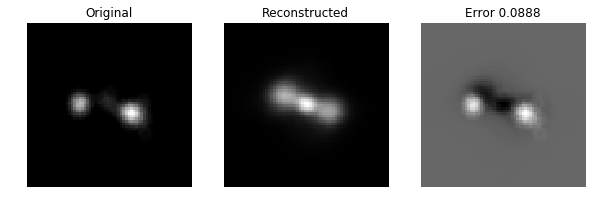

tensor([180.0066], device='cuda:0')


In [67]:
a = 15#6
s, l = sample[0][a:a+1], sample[1][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
    rot = torch.sigmoid(e[:,-1])
    d = vae.decode(e[:,:-1])
    s = rotate_tensor(s, rot)

s_n = s.numpy() - s.numpy().min()

f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(s_n[0][0], cmap='gray')
ax[1].imshow(d.cpu()[0][0], cmap='gray')
ax[2].imshow(s_n[0][0] - d.cpu().numpy()[0][0], cmap='gray')
bce = F.binary_cross_entropy(torch.FloatTensor(s_n[0][0]), d.cpu())

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

ax[0].set_title('Original')
ax[1].set_title('Reconstructed')
ax[2].set_title('Error {:.4f}'.format(bce))
plt.show()
print(rot*360)

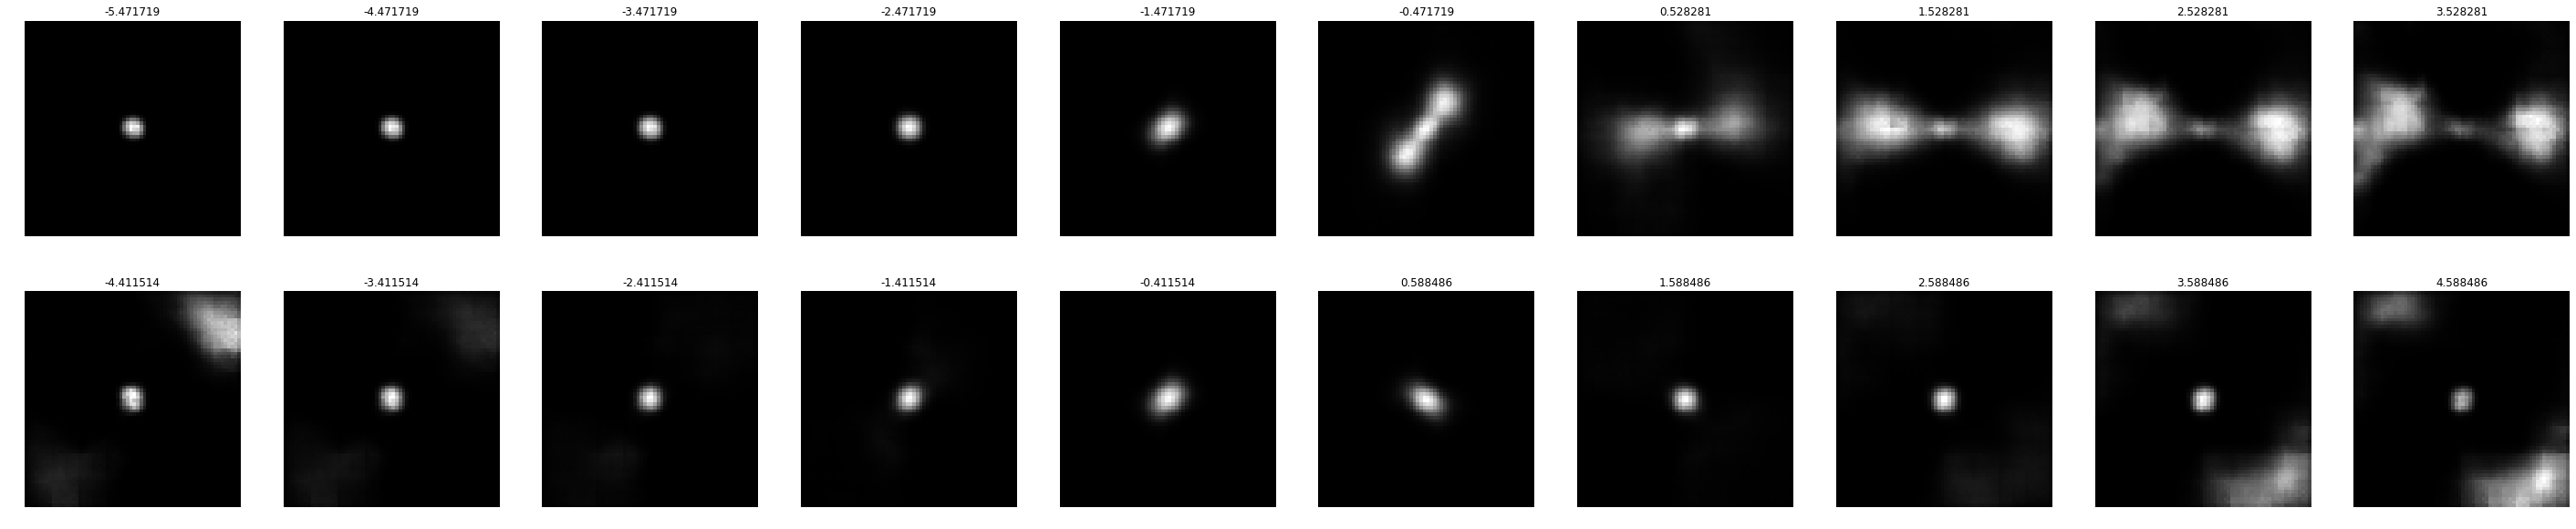

In [56]:
r = 10
nimg = r * lt_dim
k = 1
m = 1
f, ax = plt.subplots(int(nimg/r), r, figsize=(r * 5, nimg * 5 / r))
for i in range(int(nimg/r)):
    for j in range(r):
        with torch.no_grad():
            e = vae.encode(s.to(device))[0]
            v = e[0][i]
            nv = -4*k + v + k*j
            e[0][i] = nv
            d = vae.decode(e[:,:-1]).cpu()[0][0]
        ax[i][j].imshow(d, cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title('{:2f}'.format(nv))

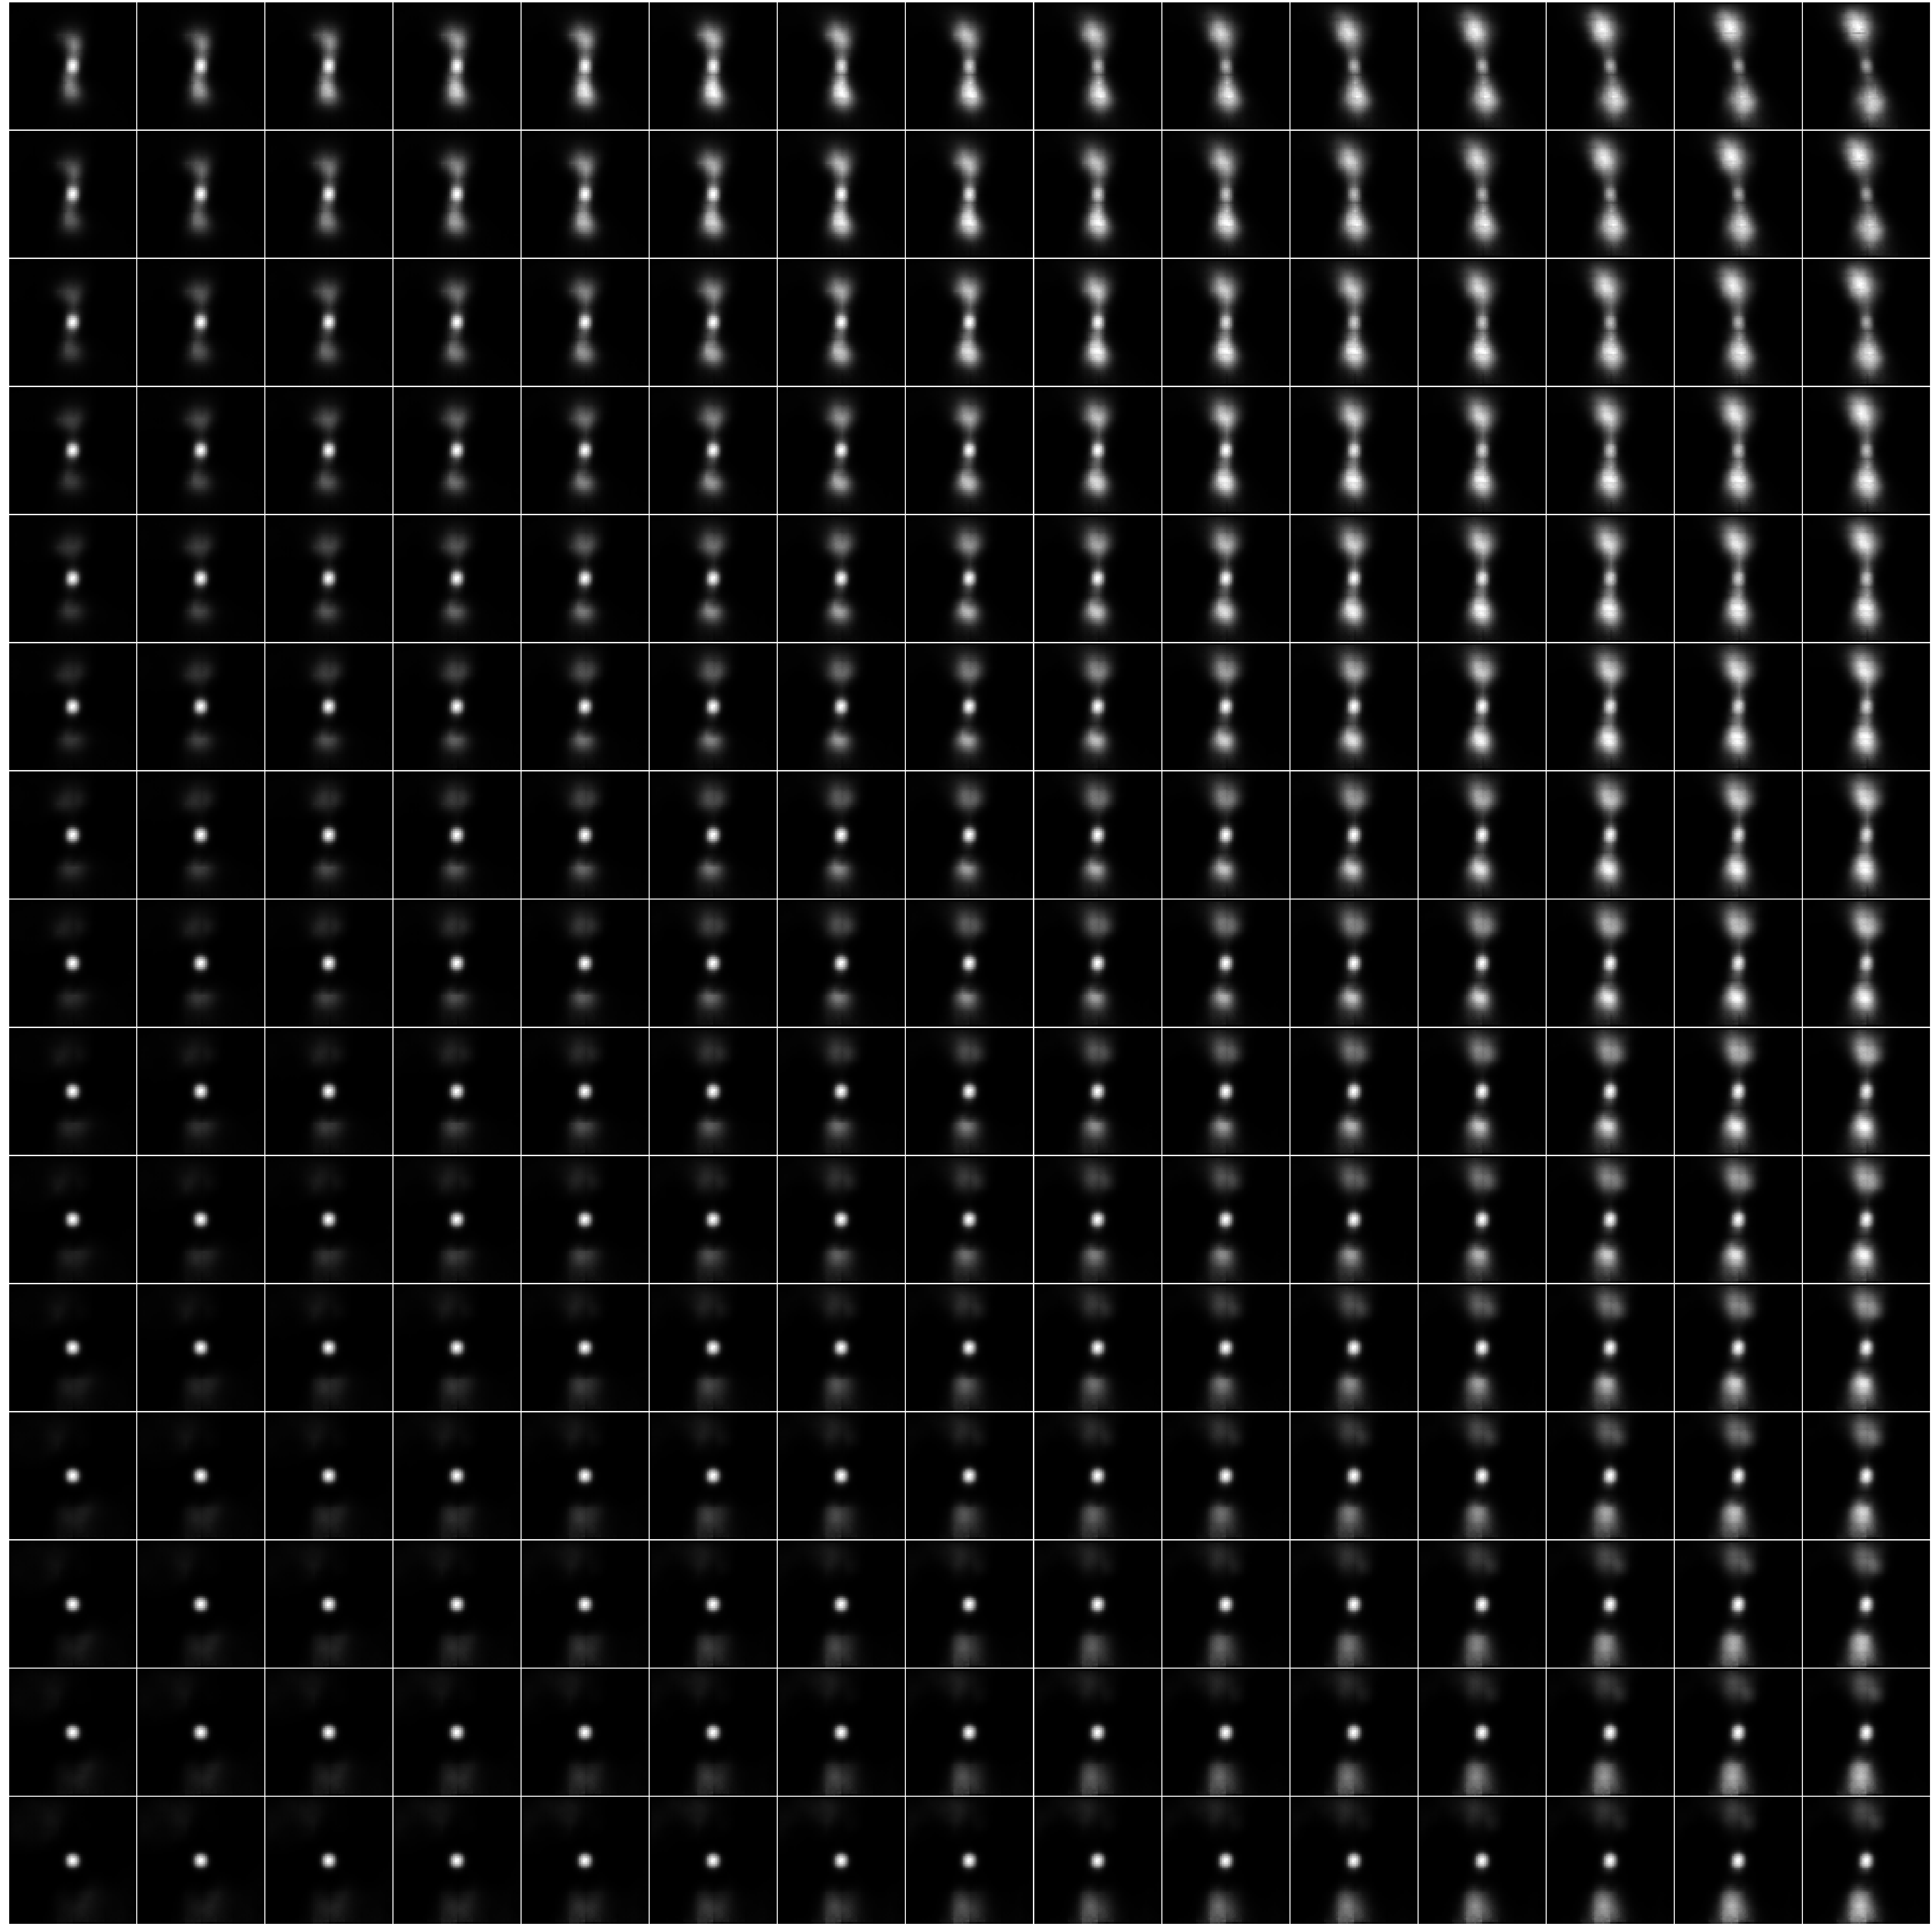

In [68]:
r = 15
nimg = r * 15

plt.figure(figsize=(101.3, 104))
gs1 = gridspec.GridSpec(15, r)
gs1.update(wspace=0.01, hspace=0.01)

k=0.2

for i in range(15):
    for j in range(r):
        ax1 = plt.subplot(gs1[i*r+j])
        plt.axis('off')
        with torch.no_grad():
            e = torch.Tensor([(-j/2 + j)*k, (-i/2  + i)*k]).cuda()
            d = vae.decode(e).cpu()[0][0]
        ax1.imshow(d, cmap='gray')
        ax1.set_aspect('equal')